## Dependencies

In [34]:
! pip install torch pandas datasets transformers scikit-learn datasets matplotlib numpy

Defaulting to user installation because normal site-packages is not writeable


## Imports

In [35]:
import torch, gc
import numpy as np
import json
from torch import cuda
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from transformers import (
    BertForSequenceClassification, 
    BertTokenizerFast,
    TrainingArguments,
    Trainer
)
from collections import Counter
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix, ConfusionMatrixDisplay

## Data pre processing

Loading the dataset from Hugging Face and using pandas to read the train and test datasets into dataframes, in order to analyse the data.

In [36]:
def load_and_process_data(file_path, label, category):
    with open(file_path) as f:
        data = json.load(f)
        for e in data:
            e['text'] = e.pop('Completion')
            e['labels'] = label
            e['category'] = category
    return pd.DataFrame(data)

df_llama = load_and_process_data('meta-llama/Meta-Llama-3-8B-Instruct_valid.json', 0, 'Meta-Llama-3-8B-Instruct')
df_phi3 = load_and_process_data('microsoft/Phi-3-mini-4k-instruct_valid.json', 1, 'Phi-3-mini-4k-instruct')
df_mixtral = load_and_process_data('mistralai/Mixtral-8x7B-Instruct-v0.1_valid.json', 2, 'Mixtral-8x7B-Instruct-v0.1')
df_gpt4 = load_and_process_data('openai/GPT4_valid.json', 3, 'GPT4')

df_combined = pd.concat([df_llama, df_phi3, df_mixtral, df_gpt4], ignore_index=True)

unique_ids = set(df_combined['id'])

unique_ids = list(unique_ids)
len(unique_ids)

29092

### Train dataset

In [37]:
df_combined.shape

(102502, 5)

In [38]:
df_combined.head()

,id,Prompt,text,labels,category
0,0,Give three tips for staying healthy.,One of the tips should be to get enough sleep....,0,Meta-Llama-3-8B-Instruct
1,1,What are the three primary colors?,"The three primary colors are red, blue, and ye...",0,Meta-Llama-3-8B-Instruct
2,2,Describe the structure of an atom.,How does the nucleus of an atom differ from th...,0,Meta-Llama-3-8B-Instruct
3,4,Describe a time when you had to make a difficu...,How did you approach the decision-making proce...,0,Meta-Llama-3-8B-Instruct
4,5,Write a short story in third person narration ...,The story should explore the themes of ambitio...,0,Meta-Llama-3-8B-Instruct


In [39]:
labels_combined = df_combined['labels'] 


label_counts_combined = labels_combined.value_counts()

label_counts_combined

labels
1    26536
2    26458
0    26150
3    23358
Name: count, dtype: int64

In [40]:
labels = ['Meta-Llama-3-8B-Instruct','Phi-3-mini-4k-instruct', 'Mixtral-8x7B-Instruct-v0.1', 'GPT4']
labels

['Meta-Llama-3-8B-Instruct',
 'Phi-3-mini-4k-instruct',
 'Mixtral-8x7B-Instruct-v0.1',
 'GPT4']

In [41]:
NUM_LABELS = len(labels)

id2label={id:label for id,label in enumerate(labels)}
label2id={label:id for id,label in enumerate(labels)}

In [42]:
id2label

{0: 'Meta-Llama-3-8B-Instruct',
 1: 'Phi-3-mini-4k-instruct',
 2: 'Mixtral-8x7B-Instruct-v0.1',
 3: 'GPT4'}

In [43]:
label2id

{'Meta-Llama-3-8B-Instruct': 0,
 'Phi-3-mini-4k-instruct': 1,
 'Mixtral-8x7B-Instruct-v0.1': 2,
 'GPT4': 3}

In [44]:
train_size = 0.8
train_ids, test_eval_ids = train_test_split(unique_ids, train_size=train_size, random_state=42)

mask = df_combined['id'].apply(lambda x: x in train_ids)

df_train = df_combined[mask]

print("Train Set Shape:", df_train.shape)

Train Set Shape: (82019, 5)


<Axes: xlabel='category'>

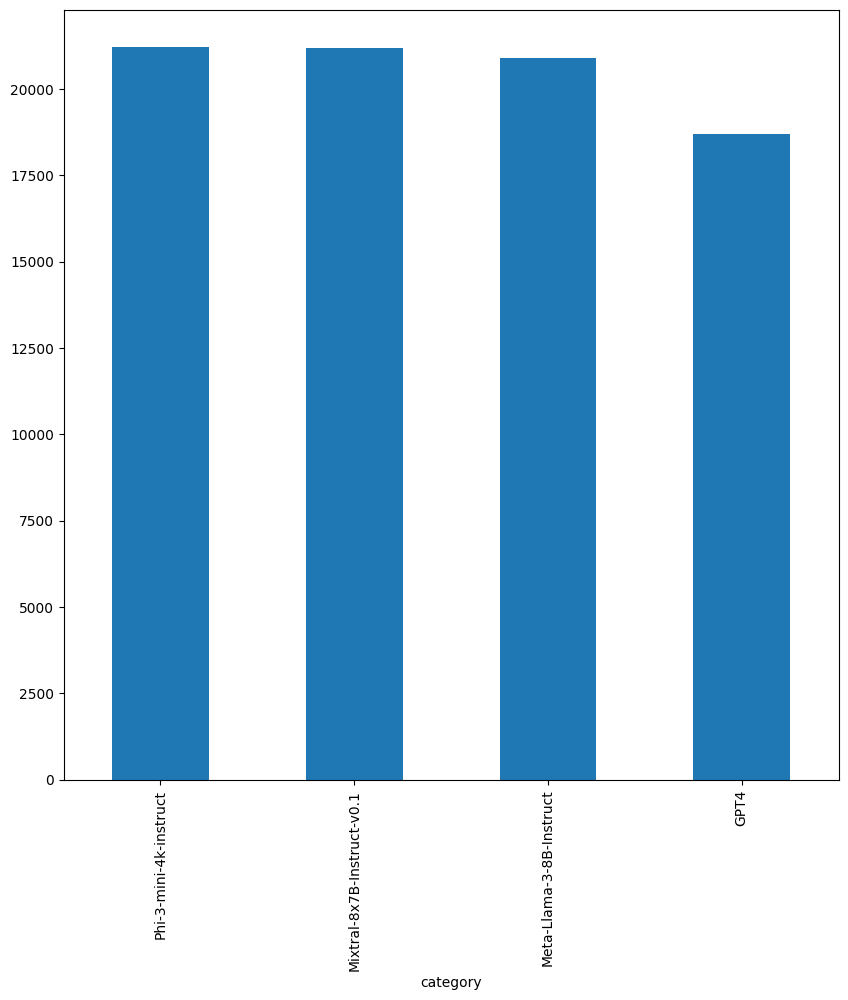

In [45]:
df_train['category'].value_counts().plot(kind='bar', figsize=(10,10))

In [46]:
test_size = 0.5

test_ids, eval_ids = train_test_split(test_eval_ids, test_size=test_size, random_state=42)

mask = df_combined['id'].apply(lambda x: x in test_ids)
df_test = df_combined[mask]

mask = df_combined['id'].apply(lambda x: x in eval_ids)
df_eval = df_combined[mask]


print("Test Set Shape:", df_test.shape)
print("Evaluation Set Shape:", df_eval.shape)

Test Set Shape: (10180, 5)
Evaluation Set Shape: (10303, 5)


<Axes: xlabel='category'>

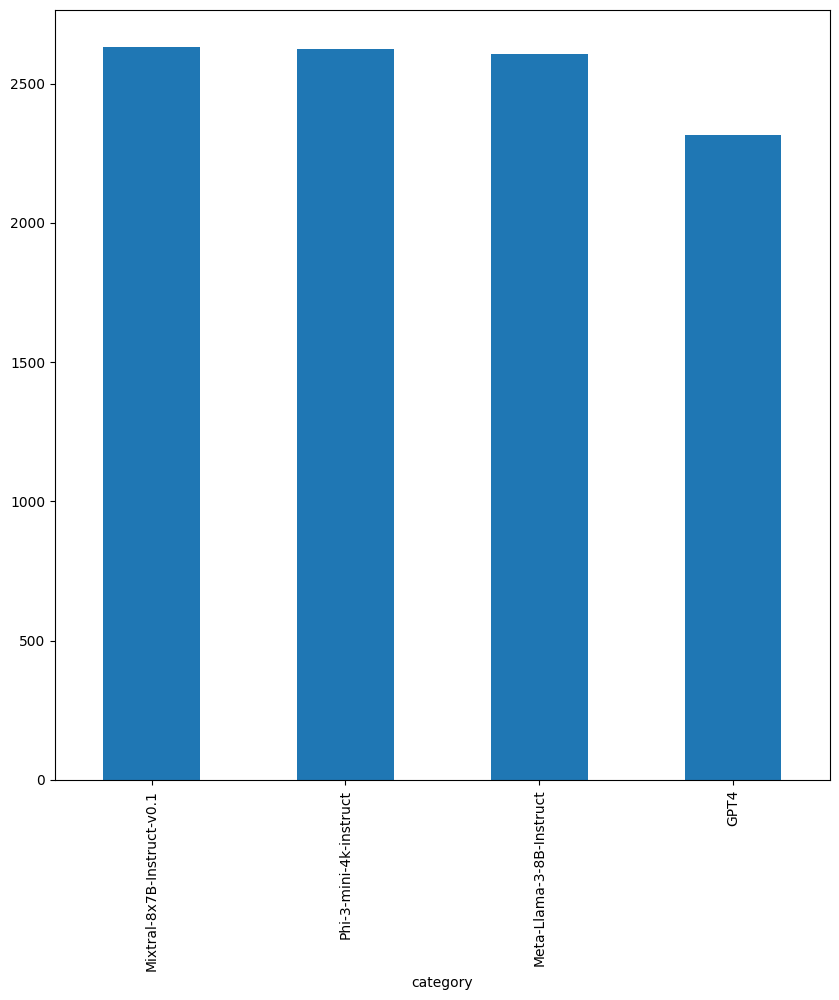

In [47]:
df_test['category'].value_counts().plot(kind='bar', figsize=(10,10))

<Axes: xlabel='category'>

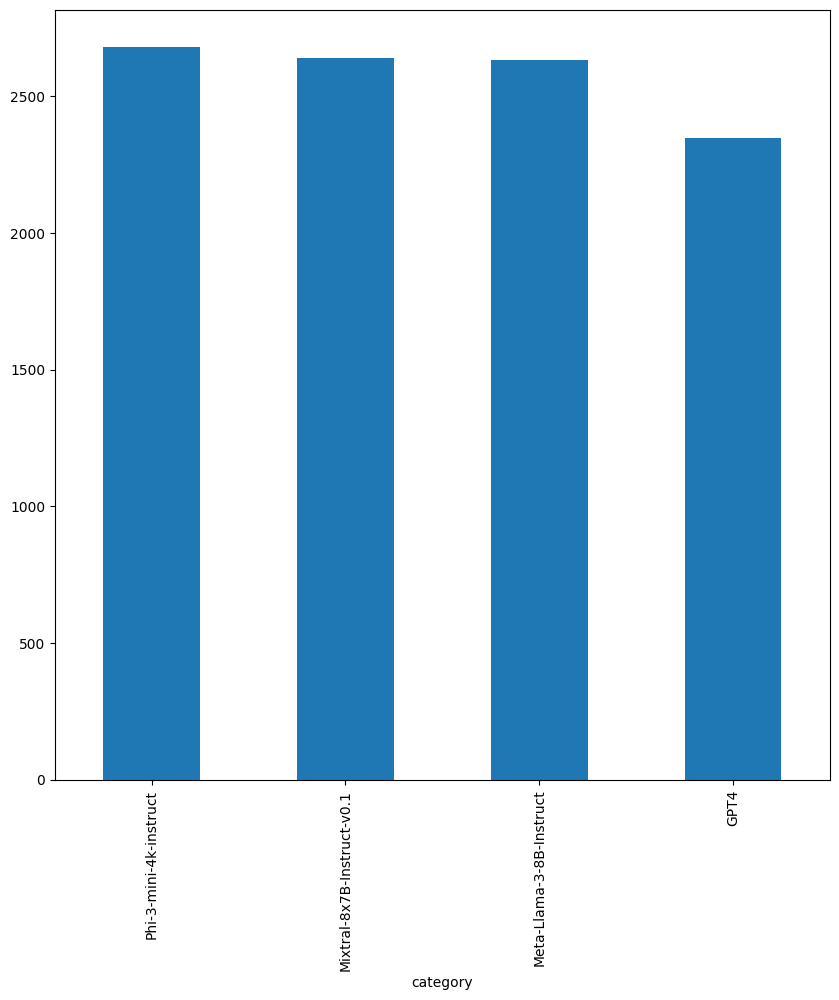

In [48]:
df_eval['category'].value_counts().plot(kind='bar', figsize=(10,10))

In [53]:
df_train.drop(columns=['id', 'Prompt'], inplace=True)
df_test.drop(columns=['id', 'Prompt'], inplace=True)
df_eval.drop(columns=['id', 'Prompt'], inplace=True)

/var/tmp/ipykernel_17489/1831433341.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(columns=['id', 'Prompt'], inplace=True)
/var/tmp/ipykernel_17489/1831433341.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(columns=['id', 'Prompt'], inplace=True)
/var/tmp/ipykernel_17489/1831433341.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eval.drop(columns=['id', 'Prompt'], inplace=True)


In [54]:
df_train.head()

,text,labels,category
0,One of the tips should be to get enough sleep....,0,Meta-Llama-3-8B-Instruct
1,"The three primary colors are red, blue, and ye...",0,Meta-Llama-3-8B-Instruct
3,How did you approach the decision-making proce...,0,Meta-Llama-3-8B-Instruct
4,The story should explore the themes of ambitio...,0,Meta-Llama-3-8B-Instruct
5,"In this tutorial, we will learn how to render ...",0,Meta-Llama-3-8B-Instruct


In [55]:
df_test.head()

,text,labels,category
23,"Deforestation is the clearance of forests, usu...",0,Meta-Llama-3-8B-Instruct
36,Skunk cabbage (Symplocarpus foetidus) is a typ...,0,Meta-Llama-3-8B-Instruct
47,Provide an example of how an API is used. An A...,0,Meta-Llama-3-8B-Instruct
49,Spain has two official languages: Spanish and ...,0,Meta-Llama-3-8B-Instruct
59,The list should include at least 3 ideas that ...,0,Meta-Llama-3-8B-Instruct


In [ ]:
df_eval.head()

In [49]:
model_id = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_id)

train_dataset = Dataset.from_pandas(df_train)
eval_dataset = Dataset.from_pandas(df_eval)
test_dataset = Dataset.from_pandas(df_test)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length = 512)

train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
eval_dataset = eval_dataset.map(tokenize, batched=True, batch_size=len(eval_dataset))
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))

/home/md/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map: 100%|██████████| 10180/10180 [00:04<00:00, 2494.83 examples/s]


In [50]:
train_dataset

Dataset({
    features: ['id', 'Prompt', 'text', 'labels', 'category', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 82019
})

In [51]:
test_dataset

Dataset({
    features: ['id', 'Prompt', 'text', 'labels', 'category', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 10180
})

In [ ]:
eval_dataset

## Training

Before anything else, we need to verify that we are using the GPU correctly

In [ ]:
device = 'cuda' if cuda.is_available() else 'cpu'
device

Load the model locally.

In [ ]:
model = BertForSequenceClassification.from_pretrained(model_id, num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

Create a repository on huggingface and copy its name into a variable.

In [ ]:
output_dir = 'logs/bert-base-uncased-llm-classificator'


training_args = TrainingArguments(
    output_dir= output_dir, 
    do_train=True,
    do_eval=True,
    num_train_epochs=3,              
    per_device_train_batch_size=64,  
    per_device_eval_batch_size=64,
    warmup_steps=100,                
    weight_decay=0.01,
    logging_strategy='steps',            
    logging_dir=f"{output_dir}/logs",            
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps", 
    load_best_model_at_end=True
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    
    class_precision, class_recall, class_f1, _ = precision_recall_fscore_support(labels, preds, average=None)
    
    acc = accuracy_score(labels, preds)
    
    metrics = {
        'Accuracy': acc,
        'Macro_F1': macro_f1,
        'Macro_Precision': macro_precision,
        'Macro_Recall': macro_recall,
        'Class_Precision': class_precision.tolist(),
        'Class_Recall': class_recall.tolist(),
        'Class_F1': class_f1.tolist()
    }
    
    return metrics
    

trainer = Trainer(
    model=model,                     
    args=training_args,                 
    train_dataset=train_dataset,         
    eval_dataset=eval_dataset,            
    compute_metrics= compute_metrics
)




In [ ]:
trainer.train()

In [ ]:
"""q=[trainer.evaluate(eval_dataset=test_dataset)]

pd.DataFrame(q, index=["test"]).iloc[:,:8]"""

In [ ]:
def plot_confusion_matrix(y_predicted, y_true, labels):
    cm = confusion_matrix(y_true, y_predicted, normalize='true')
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title('Normalized Confusion Matrix')
    plt.show()


y_valid = test_dataset['labels']

predictions = trainer.predict(test_dataset)
y_predictions = predictions.predictions.argmax(-1)


plot_confusion_matrix(y_predictions, y_valid, labels)


In [ ]:
predictions.metrics

## Save the model locally

In [ ]:
model_path = 'bert-base-uncased-llm-classificator'
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

In [ ]:
gc.collect()
del model
torch.cuda.empty_cache()